# Movie recommendation on Amazon SageMaker with Neural Networks and MXNet

### Step SM1: Download ml-100k data  
***The data sets are needed to train our Neural Network. We use the 100,000 movie ratings given by users from MovieLens data sets.***

#####  The data sets are needed to train our Factorization Machine. We use the 100,000 movie ratings given by users from MovieLens data sets.

In [1]:
!pip install pydot

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray

import pandas as pd
import numpy as np

In [3]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
s3_bucket = sess.default_bucket()
s3_prefix = 'movielens'

arn:aws:iam::349934754982:role/service-role/AmazonSageMaker-ExecutionRole-20190918T150782
CPU times: user 426 ms, sys: 16.9 ms, total: 443 ms
Wall time: 1.28 s


In [4]:
s3_bucket = sess.default_bucket()
s3_prefix = 'movielens'

### Data Information
*ua.base : data for training*  
*ua.test : data for test/validation*  
*Headers/columns :* ***user id | item id | rating (1-5) | timestamp***

In [5]:
!wget -N http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip
data = pd.read_csv('./ml-100k/u.data', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
pd.set_option('display.max_rows', 5)
data

--2019-10-29 17:45:20--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ml-100k.zip’ not modified on server. Omitting download.

Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflat

,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,196,242,3,881250949
1,186,302,3,891717742
...,...,...,...,...
99998,13,225,2,882399156
99999,12,203,3,879959583


In [6]:
train_df = pd.read_csv('./ml-100k/ua.base', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
test_df = pd.read_csv('./ml-100k/ua.test', sep='\t', names=['USER_ID', 'ITEM_ID', 'RATING', 'TIMESTAMP'])
pd.set_option('display.max_rows', 5)
train_df

,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,1,1,5,874965758
1,1,2,3,876893171
...,...,...,...,...
90568,943,1228,3,888640275
90569,943,1330,3,888692465


In [7]:
movies_df=pd.read_csv('./ml-100k/u.item', sep='|', names=['item_id','title','release_date','video_release_date','imdb_url','UNKOWN','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Noir','Horror','Musical','Mystery','Romance','SciFi','Thriller','War','Western'],encoding='latin-1')
movies_df

,item_id,title,release_date,video_release_date,imdb_url,UNKOWN,Action,Adventure,Animation,Children,...,Fantasy,Noir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def max_id(fname):
    mu = 0
    mi = 0
    with open(fname) as f:
        for line in f:
            tks = line.strip().split('\t')
            if len(tks) != 4:
                continue
            mu = max(mu, int(tks[0]))
            mi = max(mi, int(tks[1]))
    return mu + 1, mi + 1
max_users, max_items = max_id('./ml-100k/ua.base')
(max_users, max_items)

(944, 1683)

## Prepare data to push to S3

In [9]:
X_train=train_df[['USER_ID','ITEM_ID']].values
y_train=train_df[['RATING']].values

In [10]:
X_test=test_df[['USER_ID','ITEM_ID']].values
y_test=test_df[['RATING']].values

In [11]:
!mkdir ./data ./data/train ./data/test

mkdir: cannot create directory ‘./data’: File exists
mkdir: cannot create directory ‘./data/train’: File exists
mkdir: cannot create directory ‘./data/test’: File exists


In [12]:
np.save('./data/train/train_X.npy', X_train)
np.save('./data/train/train_Y.npy', y_train)
np.save('./data/test/test_X.npy', X_test)
np.save('./data/test/test_Y.npy', y_test)

In [13]:
traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)
output_s3 = 's3://{}/{}/models/'.format(s3_bucket, s3_prefix)
code_location_s3 = 's3://{}/{}/codes'.format(s3_bucket, s3_prefix)

In [14]:
train_s3 = sess.upload_data(path='./data/train/', bucket=s3_bucket, key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path='./data/test/', bucket=s3_bucket, key_prefix=testdata_s3_prefix)

In [15]:
inputs = {'train':train_s3, 'test': test_s3}

## Network Architecture

In [16]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_latent_factors = 32

Using MXNet backend


We start with a linear model architecture. This is essentially the same exercise as learning two matrices U,I such that UxI = R and we are back to the original Matrix Facotization problem. We have 3 components, user and item embeddings and a final dot product to evaluate our predicted ratings.

In [17]:
def lin_net():
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(max_items, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(max_users, n_latent_factors,name='User-Embedding')(user_input))

    prod = keras.layers.dot([movie_vec, user_vec],axes=1,name='DotProduct')
    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    return model

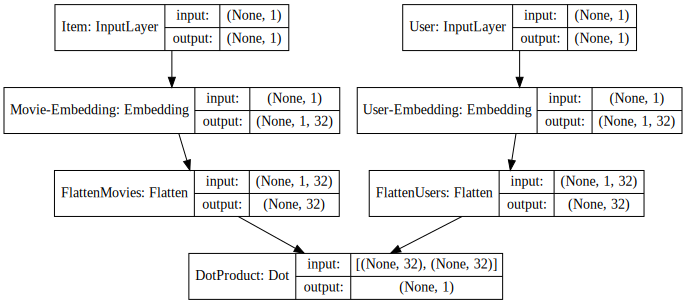

In [18]:
net=lin_net()
SVG(model_to_dot(net,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [19]:
model=lin_net()
model.summary()
model.fit([X_train[:,0], X_train[:,1]], y_train, epochs=10, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 32)        53856       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        30208       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


90570/90570 [==============================] - 8s 83us/step - loss: 6.8430
Epoch 2/10
90570/90570 [==============================] - 8s 92us/step - loss: 1.1143
Epoch 3/10
90570/90570 [==============================] - 8s 92us/step - loss: 0.9318
Epoch 4/10
90570/90570 [==============================] - 8s 93us/step - loss: 0.8816
Epoch 5/10
90570/90570 [==============================] - 8s 93us/step - loss: 0.8484
Epoch 6/10
90570/90570 [==============================] - 8s 93us/step - loss: 0.8180
Epoch 7/10
90570/90570 [==============================] - 8s 93us/step - loss: 0.7862
Epoch 8/10
90570/90570 [==============================] - 8s 93us/step - loss: 0.7525
Epoch 9/10
90570/90570 [==============================] - 8s 93us/step - loss: 0.7134
Epoch 10/10
90570/90570 [==============================] - 8s 93us/step - loss: 0.6718


## Evaluate

In [20]:
predictions = model.predict([X_test[:,0],X_test[:,1]])

In [21]:
predictions

array([[3.8316786],
       [3.4096637],
       [3.9984334],
       ...,
       [2.906744 ],
       [2.9481337],
       [3.517941 ]], dtype=float32)

In [22]:
model.predict([X_test[0:1,0],X_test[0:1,1]])

array([[3.8316786]], dtype=float32)

In [23]:
user_nb=3
movie_nb=45
model.predict([np.array([user_nb]),np.array([movie_nb])])

array([[3.6093092]], dtype=float32)

## Display recommendations

In [24]:
movies={}
for index, row in movies_df.iterrows():
    movies[int(row['item_id'])]= row['title']

In [25]:
user_nb=3
score_threshold=2
maximum_recommendations=20

In [26]:
recommended_movies=[]
for movieId in range(max_items):
    result_score=model.predict([np.array([user_nb]),np.array([movieId])])
    if result_score > score_threshold:
        recommended_movies.append([int(movieId),result_score])

In [27]:
def getVal(item):
    return item[1]
recommended_movies=sorted(recommended_movies,key=getVal,reverse=True)

In [28]:
!pip install tabulate
import tabulate
from IPython.display import HTML, display

    100% |████████████████████████████████| 51kB 14.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for tabulate ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e1/41/5e/e201f95d90fc84f93aa629b6638adacda680fe63aac47174ab
Successfully built tabulate
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
output_table = [['<strong>Movie Title</strong>','<strong>Score</strong>']]
for i in range(min(maximum_recommendations,len(recommended_movies))):
    output_table.append([movies[int(recommended_movies[i][0])],recommended_movies[i][1][0][0]])

display(HTML(tabulate.tabulate(output_table, tablefmt='html')))

Movie Title,Score
Pather Panchali (1955),4.536285877227783
Anna (1996),4.251973628997803
Faust (1994),4.053378105163574
Maya Lin: A Strong Clear Vision (1994),3.9724650382995605
Some Mother's Son (1996),3.9518790245056152
"Saint of Fort Washington, The (1993)",3.9363317489624023
Two or Three Things I Know About Her (1966),3.927175521850586
"Close Shave, A (1995)",3.912405252456665
Paradise Lost: The Child Murders at Robin Hood Hills (1996),3.8960773944854736
Kaspar Hauser (1993),3.869779348373413


## Train model on Sagemaker

In [30]:
from sagemaker.mxnet import MXNet, MXNetModel

In [31]:
mxnet_estimator = MXNet('keras_rec.py',
                        role=role,
                        train_instance_type='ml.c4.xlarge',
                        train_instance_count=1,
                        framework_version='1.4.1',
                        py_version='py3',
                        hyperparameters={'batch-size': 32,'epochs': 10,'learning-rate': 0.1,'embedding-size':32,'max-users':max_users,'max-items':max_items})
mxnet_estimator.fit(inputs)

2019-10-29 17:48:33 Starting - Starting the training job...
2019-10-29 17:48:36 Starting - Launching requested ML instances......
2019-10-29 17:49:34 Starting - Preparing the instances for training...
2019-10-29 17:50:24 Downloading - Downloading input data...
2019-10-29 17:50:55 Training - Training image download completed. Training in progress.2019-10-29 17:50:55,616 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-10-29 17:50:55,619 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-10-29 17:50:55,632 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":32,"embedding-size":32,"epochs":10,"learning-rate":0.1,"max-items":1683,"max-users":944}', 'SM_USER_ENTRY_POINT': 'keras_rec.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}

90570/90570 [==============================] - 7s 75us/step - loss: 6.8103
Epoch 2/10

66880/90570 [=====================>........] - ETA: 1s - loss: 1.1562


90570/90570 [==============================] - 7s 78us/step - loss: 1.1138
Epoch 3/10

90570/90570 [==============================] - 7s 78us/step - loss: 0.9374
Epoch 4/10

13472/90570 [===>..........................] - ETA: 6s - loss: 0.8732


90570/90570 [==============================] - 7s 78us/step - loss: 0.8951
Epoch 5/10

51520/90570 [================>.............] - ETA: 3s - loss: 0.8612


90570/90570 [==============================] - 7s 78us/step - loss: 0.8641
Epoch 6/10

90570/90570 [==============================] - 7s 78us/step - loss: 0.8293
Epoch 7/10



90570/90570 [==============================] - 7s 78us/step - loss: 0.7931
Epoch 8/10
38048/90570 [===========>..................] - ETA: 4s - loss: 0.7440


90570/90570 [==============================] - 7s 77us/step - loss: 0.7569
Epoch 9/10

76032/90570 [========================>.....] - ETA: 1s - loss: 0.7152


90570/90570 [==============================] - 7s 78us/step - loss: 0.7166
Epoch 10/10

90570/90570 [==============================] - 7s 78us/step - loss: 0.6759
MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  /opt/ml/model/model-symbol.json
MXNet params file -  /opt/ml/model/model-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/User1', '/Item1']
data_shapes :  [DataDesc[/User1,(32, 1),float32,NCHW], DataDesc[/Item1,(32, 1),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.
2019-10-29 17:52:10,119 sagemaker-containers INFO     Reporting training SUCCESS



2019-10-29 17:52:17 Uploading - Uploading generated training model
2019-10-29 17:52:17 Completed - Training job completed
Training seconds: 113
Billable seconds: 113


## Non-linear Architecture

In [32]:
def nl_net():
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(max_items, n_latent_factors, name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    

    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(max_users, n_latent_factors,name='User-Embedding')(user_input))

    concat = keras.layers.concatenate([movie_vec, user_vec],name='Concat')
    concat_dropout = keras.layers.Dropout(0.2)(concat)
    dense = keras.layers.Dense(200,name='FullyConnected', activation='relu')(concat)
    dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
    dense_2 = keras.layers.Dense(100,name='FullyConnected-1',activation='relu')(concat)
    dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = keras.layers.Dense(50,name='FullyConnected-2', activation='relu')(dense_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)
        
    result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
    adam = Adam(lr=0.005)
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model

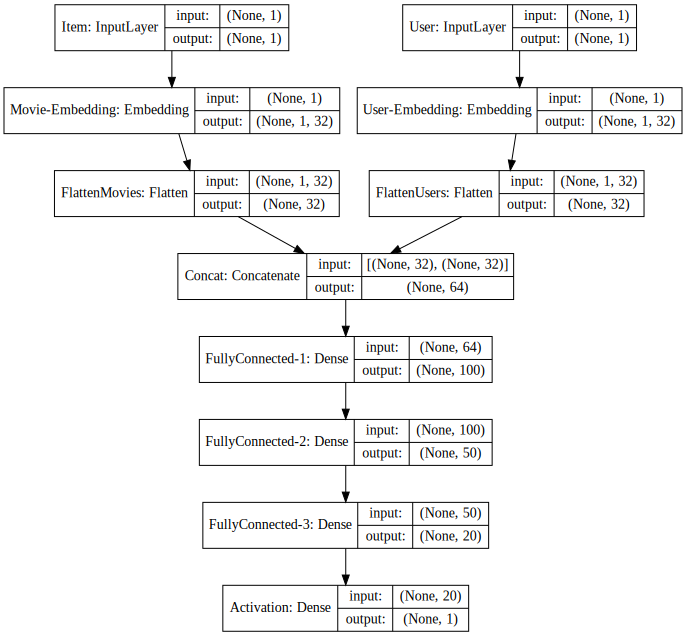

In [33]:
net=nl_net()
SVG(model_to_dot(net,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [34]:
model=nl_net()
model.summary()
model.fit([X_train[:,0], X_train[:,1]], y_train, epochs=10, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 32)        53856       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 32)        30208       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


90570/90570 [==============================] - 10s 112us/step - loss: 0.8018
Epoch 2/10
90570/90570 [==============================] - 11s 122us/step - loss: 0.7345
Epoch 3/10
90570/90570 [==============================] - 12s 128us/step - loss: 0.7137
Epoch 4/10
90570/90570 [==============================] - 13s 149us/step - loss: 0.7010
Epoch 5/10
90570/90570 [==============================] - 16s 174us/step - loss: 0.6908
Epoch 6/10
90570/90570 [==============================] - 17s 183us/step - loss: 0.6806
Epoch 7/10
90570/90570 [==============================] - 13s 143us/step - loss: 0.6724
Epoch 8/10
90570/90570 [==============================] - 13s 144us/step - loss: 0.6639
Epoch 9/10
90570/90570 [==============================] - 13s 146us/step - loss: 0.6574
Epoch 10/10
90570/90570 [==============================] - 13s 147us/step - loss: 0.6515


In [35]:
predictions = model.predict([X_test[:,0],X_test[:,1]])

In [36]:
predictions

array([[3.9099874],
       [3.181464 ],
       [3.9850137],
       ...,
       [2.990262 ],
       [2.990262 ],
       [3.8768935]], dtype=float32)

## Train on Sagemaker

In [37]:
mxnet_estimator = MXNet('keras_rec_nl.py',
                        role=role,
                        train_instance_type='ml.c4.xlarge',
                        train_instance_count=1,
                        framework_version='1.4.1',
                        py_version='py3',
                        hyperparameters={'batch-size': 32,'epochs': 10,'learning-rate': 0.1,'embedding-size':32,'max-users':max_users,'max-items':max_items})
mxnet_estimator.fit(inputs)

2019-10-29 17:59:08 Starting - Starting the training job...
2019-10-29 17:59:12 Starting - Launching requested ML instances......
2019-10-29 18:00:14 Starting - Preparing the instances for training...
2019-10-29 18:01:06 Downloading - Downloading input data...
2019-10-29 18:01:37 Training - Training image download completed. Training in progress..2019-10-29 18:01:38,218 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-10-29 18:01:38,220 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-10-29 18:01:38,234 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":32,"embedding-size":32,"epochs":10,"learning-rate":0.1,"max-items":1683,"max-users":944}', 'SM_USER_ENTRY_POINT': 'keras_rec_nl.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"et

90570/90570 [==============================] - 15s 160us/step - loss: 0.9043
Epoch 3/10

26880/90570 [=======>......................] - ETA: 10s - loss: 0.9074


89376/90570 [============================>.] - ETA: 0s - loss: 0.9040


90570/90570 [==============================] - 14s 160us/step - loss: 0.9039
Epoch 4/10

61184/90570 [===================>..........] - ETA: 4s - loss: 0.9010


90570/90570 [==============================] - 15s 161us/step - loss: 0.9038
Epoch 5/10

32832/90570 [=========>....................] - ETA: 9s - loss: 0.9107


90570/90570 [==============================] - 14s 160us/step - loss: 0.9044
Epoch 6/10

 4736/90570 [>.............................] - ETA: 14s - loss: 0.9096


66912/90570 [=====================>........] - ETA: 3s - loss: 0.9038


90570/90570 [==============================] - 15s 161us/step - loss: 0.9035
Epoch 7/10

38560/90570 [===========>..................] - ETA: 8s - loss: 0.9021


90570/90570 [==============================] - 15s 161us/step - loss: 0.9036
Epoch 8/10

41888/90570 [============>.................] - ETA: 7s - loss: 0.9066


90570/90570 [==============================] - 14s 160us/step - loss: 0.9039
Epoch 9/10

13696/90570 [===>..........................] - ETA: 12s - loss: 0.9246


76096/90570 [========================>.....] - ETA: 2s - loss: 0.9044


90570/90570 [==============================] - 15s 160us/step - loss: 0.9039
Epoch 10/10

48032/90570 [==============>...............] - ETA: 6s - loss: 0.9029



2019-10-29 18:04:10 Uploading - Uploading generated training model48352/90570 [===============>..............] - ETA: 6s - loss: 0.9023
90570/90570 [==============================] - 15s 161us/step - loss: 0.9042
MXNet Backend: Successfully exported the model as MXNet model!
MXNet symbol file -  /opt/ml/model/model-symbol.json
MXNet params file -  /opt/ml/model/model-0000.params


Model input data_names and data_shapes are: 
data_names :  ['/User1', '/Item1']
data_shapes :  [DataDesc[/User1,(32, 1),float32,NCHW], DataDesc[/Item1,(32, 1),float32,NCHW]]


Note: In the above data_shapes, the first dimension represent the batch_size used for model training. 
You can change the batch_size for binding the module based on your inference batch_size.
2019-10-29 18:04:06,651 sagemaker-containers INFO     Reporting training SUCCESS



2019-10-29 18:04:15 Completed - Training job completed
Training seconds: 189
Billable seconds: 189


In [53]:
fm_predictor = mxnet_estimator.deploy(instance_type='ml.t2.medium', initial_instance_count=1)

--------------------------------------------------------------------------------------------------!

## Evaluate

In [38]:
predictions = model.predict([X_test[:,0],X_test[:,1]])

In [39]:
predictions

array([[3.9099874],
       [3.181464 ],
       [3.9850137],
       ...,
       [2.990262 ],
       [2.990262 ],
       [3.8768935]], dtype=float32)

In [40]:
user_nb=3
movie_nb=45
model.predict([np.array([user_nb]),np.array([movie_nb])])

array([[3.5918612]], dtype=float32)

## Display recommendations

In [41]:
user_nb=3
score_threshold=2
maximum_recommendations=20

In [42]:
recommended_movies=[]
for movieId in range(max_items):
    result_score=model.predict([np.array([user_nb]),np.array([movieId])])
    if result_score > score_threshold:
        recommended_movies.append([int(movieId),result_score])

In [43]:
def getVal(item):
    return item[1]
recommended_movies=sorted(recommended_movies,key=getVal,reverse=True)

In [44]:
output_table = [['<strong>Movie Title</strong>','<strong>Score</strong>']]
for i in range(min(maximum_recommendations,len(recommended_movies))):
    output_table.append([movies[int(recommended_movies[i][0])],recommended_movies[i][1][0][0]])

display(HTML(tabulate.tabulate(output_table, tablefmt='html')))

Movie Title,Score
"Saint of Fort Washington, The (1993)",4.846966743469238
Anna (1996),4.432531356811523
Santa with Muscles (1996),4.310690879821777
Prefontaine (1997),4.269065856933594
Schindler's List (1993),4.258083343505859
Casablanca (1942),4.215717315673828
"Usual Suspects, The (1995)",4.198036193847656
"Princess Bride, The (1987)",4.177254676818848
Pather Panchali (1955),4.174709320068359
Citizen Kane (1941),4.1515889167785645


***Compare the recommendation with the top 20 movies that are actually rated by that particular user, sorted from the highest rating***

In [49]:
nbUsers=943
nbMovies=1682
nbFeatures=nbUsers+nbMovies

nbRatingsTrain=90570
nbRatingsTest=9430

In [51]:
import csv
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)]=[]
 
with open('./ml-100k/ua.base','r') as f:
    samples=csv.reader(f,delimiter='\t')
    for userId,movieId,rating,timestamp in samples:
        moviesByUser[str(int(userId)-1)].append([int(movieId)-1,rating]) 

In [52]:
def find_top_rated_movies(user_id, k):
    rated_movies = moviesByUser[str(int(user_id)-1)]
    rated_movies = sorted(rated_movies,key=getVal,reverse=True)
    results = []
    
    for movie in rated_movies:
        results.append([movies[int(movie[0]+1)],movie[1]])
    return results[0:k]

output_table = [['<strong>Movie Title</strong>','<strong>Actual Rating</strong>']]
for m in find_top_rated_movies(user_nb,20):
    output_table.append(m)

display(HTML(tabulate.tabulate(output_table, tablefmt='html')))


Movie Title,Actual Rating
Paradise Lost: The Child Murders at Robin Hood Hills (1996),5
Mother (1996),5
Boogie Nights (1997),5
Jackie Brown (1997),5
Wag the Dog (1997),5
Return of the Jedi (1983),4
Event Horizon (1997),4
Schindler's List (1993),4
Cop Land (1997),4
Desperate Measures (1998),4
